In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from argparse import ArgumentParser
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.datasets.factory import FactoryDataset 
from pytvision.datasets.datasets import Dataset
from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.neuralnet import NeuralNetClassifier
from misc import get_transforms_det

from sklearn import metrics

In [2]:
pathname = os.path.expanduser( '~/.datasets' )
projectnet='../out/netruns'
name_dataset=FactoryDataset.affect
no_cuda=False
seed=1
gpu=1
batch_size=60
workers=10
num_input_channels=3

print(pathname)
print(projectnet)
print(name_dataset)

/home/fernandez/.datasets
../out/netruns
affectnet


In [3]:
!ls ../out/netruns/

baseline_preactresnet18_cross_adam_affectnet_imsize32_gray_weights_000
baseline_preactresnet18_cross_sgd_affect_000
baseline_preactresnet18_cross_sgd_affectnet_000
baseline_preactresnet18_cross_sgd_affectnet_weights_000
ferbase_preactresnet18_cross_adam_bu3dfe_fold0_000
ferbase_preactresnet18_cross_adam_real_bu3dfe_fold0_000
ferbase_preactresnet18_cross_sgd_real_bu3dfe_fold0_000


In [4]:
name = 'baseline_preactresnet18_cross_adam_affectnet_imsize32_gray_weights_000'
project = os.path.join(projectnet, name)
model = 'model_best.pth.tar' #'chk000025.pth.tar', model_best
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)

../out/netruns/baseline_preactresnet18_cross_adam_affectnet_imsize32_gray_weights_000
../out/netruns/baseline_preactresnet18_cross_adam_affectnet_imsize32_gray_weights_000/models/model_best.pth.tar


## Load model

In [5]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

=> loading checkpoint '../out/netruns/baseline_preactresnet18_cross_adam_affectnet_imsize32_gray_weights_000/models/model_best.pth.tar'
=> loaded checkpoint for preactresnet18 arch!


In [6]:

name_dataset=FactoryDataset.affectdark
subset=FactoryDataset.validation

data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=subset, 
        download=True ),
    num_channels=num_input_channels,
    transform=get_transforms_det(network.size_input)
    )

# data = SyntheticFaceDataset(
#     data=FactoryDataset.factory(
#         pathname=pathname, 
#         name=name_dataset, 
#         subset=subset, 
#         download=True 
#         ),
#     pathnameback='~/.datasets/coco', 
#     generate='image_and_label',
#     ext='jpg',
#     count=2000,
#     num_channels=3,
#     iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
#     #iluminate=True, angle=45, translation=0.1, warp=0.0, factor=0.0,
#     transform=get_transforms_det(network.size_input)
#     )


dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader ')
print(len(dataloader))
print(len(data))

Data loader 
67
4000


In [7]:
Yhat, Y = network.test( dataloader )
df = pd.DataFrame( np.concatenate((Yhat, Y), axis=1) )
df.to_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset,name,name_dataset)), index=False, encoding='utf-8')       

print('dir: {}'.format(project))
print('DONE!!!')

100%|██████████| 67/67 [00:02<00:00, 23.26it/s]

dir: ../out/netruns/baseline_preactresnet18_cross_adam_affectnet_imsize32_gray_weights_000
DONE!!!


In [8]:
df = pd.read_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset, name, name_dataset))  )
df.head()

,0,1,2,3,4,5,6,7,8
0,0.002436,0.006261,0.000271,0.004019,0.002375,0.006420,0.000280,0.977939,7.0
1,0.355745,0.000790,0.074175,0.521086,0.025943,0.000510,0.021104,0.000646,0.0
2,0.113457,0.001904,0.090351,0.070472,0.551933,0.091790,0.076350,0.003742,0.0
3,0.172593,0.001020,0.066972,0.080591,0.050622,0.000114,0.626424,0.001665,6.0
4,0.712495,0.005091,0.031731,0.083784,0.141648,0.000251,0.011279,0.013722,0.0


In [14]:
result = df.as_matrix()
yhat = np.argmax( result[:,:-1], axis=1 )
y = result[:,-1]

acc = metrics.accuracy_score(y, yhat)
precision = metrics.precision_score(y, yhat, average='macro')
recall = metrics.recall_score(y, yhat, average='macro')
f1_score = 2*precision*recall/(precision+recall)

print('Accuracy : %f' % acc)
print('Precision : %f' % precision)
print('Recall : %f' % recall)
print('F1 score : %f' % f1_score)
print("")

print( '{:0.3f}\n{:0.3f}\n{:0.3f}\n{:0.3f}'.format(acc,precision,recall,f1_score).replace('.',',')  )


Accuracy : 0.494750
Precision : 0.504170
Recall : 0.494750
F1 score : 0.499415

0,495
0,504
0,495
0,499


In [10]:
metric = metrics.classification_report(y, yhat)
print(metric)

             precision    recall  f1-score   support

        0.0       0.47      0.47      0.47       500
        1.0       0.72      0.70      0.71       500
        2.0       0.53      0.58      0.55       500
        3.0       0.62      0.44      0.52       500
        4.0       0.46      0.60      0.52       500
        5.0       0.54      0.54      0.54       500
        6.0       0.62      0.51      0.56       500
        7.0       0.54      0.59      0.56       500

avg / total       0.56      0.55      0.55      4000



In [11]:
mc = metrics.confusion_matrix(y, yhat)
print(mc)

[[236   9  50  30  72  18  16  69]
 [ 13 351  21   2   3   9   4  97]
 [ 37  29 291  11  28  27  65  12]
 [ 72  16  24 221  62  52  34  19]
 [ 50   2  26  24 300  60  18  20]
 [ 23  17  20  23 100 270  18  29]
 [ 20   7 109  29  41  35 253   6]
 [ 52  56  13  15  42  26   2 294]]


Normalized confusion matrix


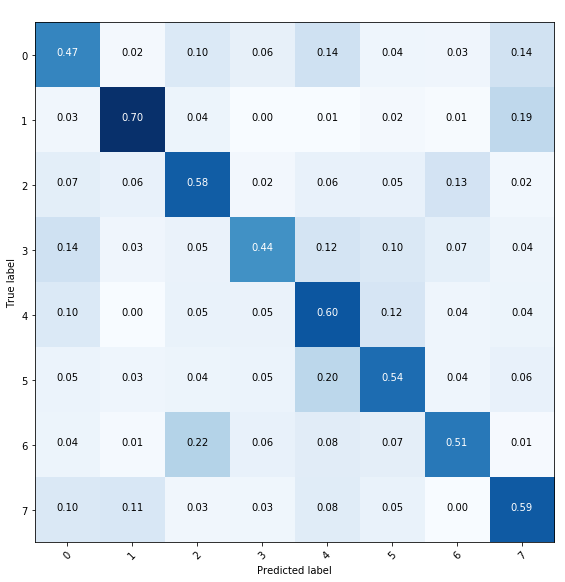

In [12]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure( figsize=(8,8))
plot_confusion_matrix(mc, classes=data.data.classes, title=' ')
plt.show()